<a href="https://colab.research.google.com/github/Nehil971/Satge_L3/blob/master/Stage1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install -U bindsnet

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 204kB 14.0MB/s 
  Created wheel for bindsnet: filename=bindsnet-0.2.6-cp36-none-any.whl size=81415 sha256=234540303cd49564abf497c0be03b0f7b74f22037266debfaa241af4568e0e42
  Stored in directory: /root/.cache/pip/wheels/92/6c/2f/f29fa692e20be42b2f42b0d0434980c8e528f62d24ee7ed5c1
Successfully built bindsnet


In [0]:
import torch
import numpy as np
from bindsnet import encoding
from torchvision import transforms
import glob
from PIL import Image
from numpy import max
import matplotlib.pyplot as plt
from tqdm import tqdm
from bindsnet.models import DiehlAndCook2015v2
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

In [0]:
def single(
        datum: torch.Tensor, time: int, dt: float = 1.0, min : float = 0, max : float = 255.0, **kwargs
) -> torch.Tensor:
    # language=rst
    """
    Generates timing based single-spike encoding. Spike occurs earlier if the
    intensity of the input feature is higher. Features whose value is lower than
    threshold is remain silent.

    :param datum: Tensor of shape ``[n_1, ..., n_k]``.
    :param time: Length of the input and output.
    :param dt: Simulation time step.
    :param sparsity: Sparsity of the input representation. 0 for no spikes and 1 for all
        spikes.
    :return: Tensor of shape ``[time, n_1, ..., n_k]``.
    """
    # [Min, Max] découpé en time intervals
    time = int(time / dt)
    shape = list(datum.shape)
    datum = np.copy(datum)
    s = np.zeros([time, *shape])
    s[0] = np.zeros(shape)
    dv = np.float((max-min)/time)
    v = np.float(max)-dv
    for t in range(time):
        mask = (datum >= v)
        #s[t] = np.where((v - dv) < datum <= v, np.ones(shape), np.zeros(shape))
        s[t] = np.where(mask, np.ones(shape), np.zeros(shape))
        v -= dv
        datum[mask] = min-1

    return torch.Tensor(s).byte()

def normalisation(data : torch.Tensor ,min : float = 0.0, max : float = 255.0):
    min2 = torch.min(data)
    max2 = torch.max(data)
    data = (data - min2) / (max2 - min2) * (max-min) + min

    return data

def LoadImg(Chemin : str, bandes : int, length : int, width : int):
  images = glob.glob(Chemin+"/*jpg")

  imtens = torch.Tensor(len(images), bandes, length, width)
  i =0
  for image in images :
    img = Image.open(image)

    ## Modification img si besoin
    if img.height != length or img.width != width:
      img = transforms.Resize((length,width))(img)

    imtens[i] = transforms.ToTensor()(img)*255

    ## Modification du bandes, de 3 vers 1:
    if imtens.size(0) > bandes:
      img = transforms.Grayscale(1)(img)
      imtens[i] = transforms.ToTensor()(img)*255

    ## Modification du bandes, de 1 vers 3:
    if imtens.size(0) < bandes:
      img = transforms.Grayscale(3)(img)
      imtens[i] = transforms.ToTensor()(img)*255
    i +=1
  return imtens


tensor([[[ 70., 133.,  23., 184., 107.,  51., 137.,  52., 117., 222., 237.,
          217., 247.],
         [249.,  14.,  95., 103.,  50.,  98.,  71.,  66.,  96.,  90., 232.,
          175.,  23.],
         [160.,  21., 194., 190., 174.,  97.,  12., 193.,  63.,  58., 149.,
          205., 189.],
         [218., 186., 121.,  44.,  93.,   6., 236., 167.,  97., 254.,   7.,
          188., 159.],
         [166.,  42.,  84.,  17., 150., 183., 255.,  36.,  81., 130.,   0.,
          199.,  90.],
         [251., 116., 158., 124., 193., 133.,  21.,  19.,  55., 219.,  62.,
          177., 218.],
         [ 96., 219., 160., 132.,  14., 242.,  24.,  37.,  10., 133., 180.,
          255., 150.],
         [ 49.,  73.,  15., 103., 218.,  85.,  38.,  97., 177., 107., 196.,
          115., 247.],
         [143.,   9., 193., 198., 153.,  95., 220.,  33., 246., 116., 187.,
          255.,  44.],
         [ 50., 220., 174.,  49.,   2., 197., 218.,  72.,   6., 142.,  81.,
          120., 214.],
         [

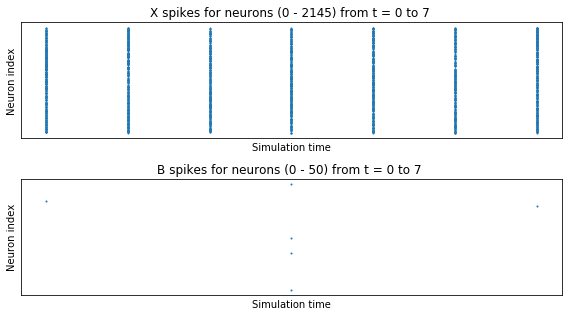

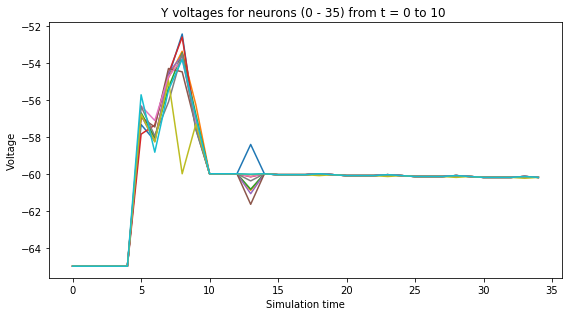

In [0]:
# VARIABLE
batch_size = 3
n_workers = 1
gpu = False
update_steps = 256
n_neurons = 10
update_interval = update_steps * batch_size
time = 7
dt = 1
length = 11
width = 13
bandes = 3

# Build Diehl & Cook 2015 network.
network = DiehlAndCook2015v2(
    n_inpt=bandes*length*width,
    n_neurons=n_neurons,
    inh=17.5,
    dt=1.0,
    norm=78.4,
    inpt_shape=(bandes, length, width),
)

# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=network.layers["X"],
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=network.layers["Y"],
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
network.add_monitor(monitor=source_monitor, name="X")
network.add_monitor(monitor=target_monitor, name="Y")

# Création des images
x = torch.empty(1, length, width).uniform_(0, 1)
img = transforms.ToPILImage()(x)
torch.save(x, 'tensor_image.pth')
img.save('pil_image2.jpg')

y = torch.empty(1, length, width).uniform_(0, 1)
img1 = transforms.ToPILImage()(y)
torch.save(y, 'tensor_image3.pth')
img1.save('pil_image4.jpg')

xy = torch.empty(1, length, width).uniform_(0, 1)
img3 = transforms.ToPILImage()(xy)
torch.save(xy, 'tensor_image5.pth')
img3.save('pil_image6.jpg')

xyz = torch.empty(1, length, width).uniform_(0, 1)
img3 = transforms.ToPILImage()(xyz)
torch.save(xy, 'tensor_image7.pth')
img3.save('pil_image8.jpg')

xyza = torch.empty(1, length, width).uniform_(0, 1)
img3 = transforms.ToPILImage()(xyza)
torch.save(xy, 'tensor_image9.pth')
img3.save('pil_image10.jpg')

imtens = LoadImg(".",bandes, length, width)

#data_encod = encoding.single(datum=imtens, time=time, dt=dt, sparsity=0.5)  # encoding.
#data_encod = encoding.repeat(datum=imtens, time=time, dt=dt, sparsity=0.5)  # encoding.
#data_encod = encoding.bernoulli(datum=imtens, time=time, dt=dt, max_prob=1)  # encoding.
#data_encod = encoding.poisson(datum=imtens, time=time, dt=dt)  # encoding.
#data_encod = encoding.rank_order(datum=imtens, time=time, dt=dt)  # encoding.
data_encod = single(datum=imtens, time=time, dt=dt,sparsity=0.5)

for i in range(imtens.size(0)):
  print(imtens[i])
  for j in range(time):
    print(data_encod[j,i])
  print("\n")
  print("img fini")
  print("\n")

inputs = {}
inputs["X"] = data_encod
network.run(inputs=inputs, time=time)

spikes = {
    "X": source_monitor.get("s"), "B": target_monitor.get("s")
    }
voltages = {"Y": target_monitor.get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()


In [0]:
dataset = torch.utils.data.TensorDataset(data_encod)
print("data loader")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=gpu)
#torch.utils.data.dataset()
print("Loop")
for step, batch in enumerate(tqdm(dataloader)):
    inputs = {"X": batch}
    for t in batch:
      print(t.size())
    

print("end loop")

#data_encod = encoding.single(data, time,dt)

  0%|          | 0/3 [00:00<?, ?it/s]

data loader
Loop


100%|██████████| 3/3 [00:00<00:00, 70.20it/s]

torch.Size([3, 5, 1, 11, 13])
torch.Size([3, 5, 1, 11, 13])
torch.Size([1, 5, 1, 11, 13])
end loop


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls /content/drive

In [0]:
!ls -al /content/pil_image63.jpg